# GDELT dataset extraction

This notebook serves as the starting point for pulling the GDELT datasets over the *english* language. Multi-lingual datasets are also [available](https://blog.gdeltproject.org/a-new-multilingual-dataset-for-exploring-climate-change-narratives-4-1-million-news-urls-in-63-languages-2015-2020/), including 4.1M articles covering the global narrative. An interesting side project would be to perform weighted clustering and analyze how different the arguments are across different languages. This would require mapping clusters across languages, which is non-trivial but possibly doable.


Full datasets found [here](https://blog.gdeltproject.org/a-new-contextual-dataset-for-exploring-climate-change-narratives-6-3m-english-news-urls-with-contextual-snippets-2015-2020/)


In [1]:
import os
from pathlib import Path
import requests
import zipfile

import pandas as pd

In [2]:
# identify project root
notebook_dir = os.getcwd()
project_root = Path(notebook_dir).resolve().parents[1]

In [3]:
BASE_URL_FMT = "http://data.gdeltproject.org/blog/2020-climate-change-narrative/WebNewsEnglishSnippets.{year}.csv.zip"

GDELT_COL_NAMES = [
    "datetime",
    "title",
    "headline_image_url",
    "content_url",
    "snippit"
]

years = list(range(2015, 2021))

In [4]:
def download_file_from_url(url, target_file_path):
    """Download a file from the given url"""
    print("downloading file from {}".format(url))
    response = requests.get(url, allow_redirects=True)
    response.raise_for_status()
    with open(target_file_path, 'wb') as f:
        f.write(response.content)
    return
    
def download_gdelt_year(year, base_url_fmt=BASE_URL_FMT):
    """
    Download the CSV files from the gdelt project, for a given year
    """
    full_url = base_url_fmt.format(year=year)
    uri_path, zip_filename = os.path.split(full_url.split("://")[1]) 
    gdelt_project_name = os.path.basename(uri_path)
    gdelt_raw_dir = os.path.join(project_root, "data", "raw", gdelt_project_name)
    os.makedirs(gdelt_raw_dir, exist_ok=True)


    zip_filepath = os.path.join(gdelt_raw_dir, zip_filename)
    csv_filename, ext = os.path.splitext(zip_filename)
    if ext != ".zip":
        raise IOError("Expected to find a zip file, found '{}' instead".format(ext))
    csv_filepath = os.path.join(gdelt_raw_dir, csv_filename)

    if not os.path.isfile(csv_filepath):
        download_file_from_url(full_url, zip_filepath)
        with zipfile.ZipFile(zip_filepath, "r") as zip_ref:
            zip_ref.extractall(gdelt_raw_dir)
        # delete the zip file when we are done with it
        if os.path.exists(zip_filepath):
            os.remove(zip_filepath)
        else:
            print("Unable to find the zip file we just extracted from: {}".format(zip_filepath))
    else:
        print("Using cached data for '{}': {}".format(year, csv_filepath))
    
    return csv_filepath

def get_gdelt_df(csv_filepath):
    # convert csv to dataframe. should probably do this in a separate step, and just return the path here.
    print("reading data from: {}".format(csv_filepath))
    df = pd.read_csv(csv_filepath, header=0, names=GDELT_COL_NAMES, index_col=False)
    return df

In [5]:
# download article URL datasets from all given years

data_paths = {}

for year in years:
    csv_path = download_gdelt_year(year)
    data_paths[str(year)] = csv_path

Using cached data for '2015': /opt/workspace/data/raw/2020-climate-change-narrative/WebNewsEnglishSnippets.2015.csv
Using cached data for '2016': /opt/workspace/data/raw/2020-climate-change-narrative/WebNewsEnglishSnippets.2016.csv
Using cached data for '2017': /opt/workspace/data/raw/2020-climate-change-narrative/WebNewsEnglishSnippets.2017.csv
Using cached data for '2018': /opt/workspace/data/raw/2020-climate-change-narrative/WebNewsEnglishSnippets.2018.csv
Using cached data for '2019': /opt/workspace/data/raw/2020-climate-change-narrative/WebNewsEnglishSnippets.2019.csv
Using cached data for '2020': /opt/workspace/data/raw/2020-climate-change-narrative/WebNewsEnglishSnippets.2020.csv


In [6]:
df = get_gdelt_df(data_paths['2015'])

reading data from: /opt/workspace/data/raw/2020-climate-change-narrative/WebNewsEnglishSnippets.2015.csv


In [7]:
df.head()

,datetime,title,headline_image_url,content_url,snippit
0,20150929221500,Sierra Leone News: As world leaders commit to ...,NaN,http://awoko.org/2015/09/29/sierra-leone-news-...,learn about the Global Goals across the globe...
1,20150715170000,Global slowdown boosts Africa's hopes of achie...,NaN,http://www.reuters.com/article/2015/07/15/deve...,will cost between $3.3 trillion and $4.5 tril...
2,20151117113000,Climate Countdown: When Is a Warming Treaty No...,http://www.sci-tech-today.com/images/super/lar...,http://www.sci-tech-today.com/news/When-s-a-Cl...,.S. and India don't want the international com...
3,20151217173000,King Abdullah II Inaugurates the First and Lar...,http://fns1.de/g/fb.png,http://www.finanznachrichten.de/nachrichten-20...,. Renewable energy contributes to achieving su...
4,20150712171500,The Marxist-Progressive Church of Climate Change,http://image.issuu.com/150710000103-324762007b...,http://www.redmond-reporter.com/opinion/letter...,scientist and an avid reader of economic book...


In [8]:
df.iloc[0][3]

'http://awoko.org/2015/09/29/sierra-leone-news-as-world-leaders-commit-to-achieving-the-sustainable-development-goals/'

In [9]:
def convert_datetime_int(datetime_int):
    """Convert an integer like 20200107101500 to a pd.Timestamp 2020.01.07T10:15:00"""
    # NOTE we still need to confirm that these times are all GMT
    datetime_str = str(datetime_int)
    if len(datetime_str) != 14:
        raise ValueError("Incorrect length for datetime integer, expected 12, found {}". format(len(datetime_str)))
    ts = pd.Timestamp(
        year=int(datetime_str[:4]),
        month=int(datetime_str[4:6]),
        day=int(datetime_str[6:8]),
        hour=int(datetime_str[8:10]),
        minute=int(datetime_str[10:12]),
        second=int(datetime_str[12:14]),
    )
    return ts

In [10]:
df['timestamp'] = df.datetime.apply(convert_datetime_int)

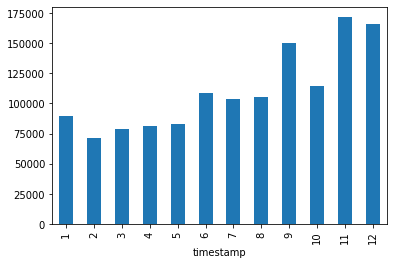

In [12]:
# plot the distribution by day of month
df.timestamp.groupby([df["timestamp"].dt.month]).count().plot(kind="bar")

# Next: test the API
Great, now we have the data downloaded locally. 
The 2020 dataset is incomplete, only containing data from January 2020.

Of note, a significant proportion of the articles linked may no longer be accessible. When we build the API wrapper and output object, make sure we have a clear way to keep track of which articles no longer exist, and note them as such. Even the lack of existence of an article may have signal in the arguments being mined.